<div class="output_png output_subarea output_execute_result">
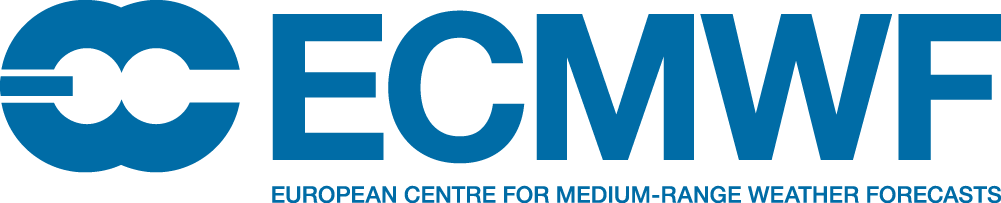
</div>

# Total snowfall during last 6 hours

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-snowfall 


<div class="output_png output_subarea output_execute_result">
<center>
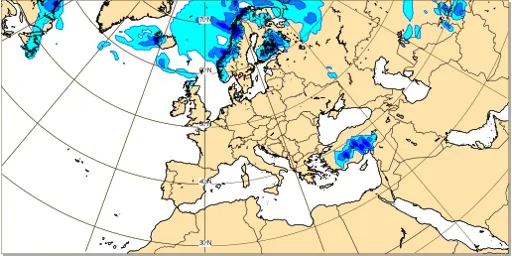
</div>

Some ECMWF real-time products are governed by the [ECMWF Standard Licence Agreement](https://www.ecmwf.int/sites/default/files/ECMWF_Standard_Licence.pdf) and are not free or open. Access to these products depends on your use case. To find out which licence applies to you, please visit: [Use cases and licence conditions page](https://www.ecmwf.int/en/forecasts/accessing-forecasts/licences-available).  

To find out how to obtain the access to the ECMWF forecast data please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input following parameter:

* [Snowfall](https://codes.ecmwf.int/grib/param-db/144)

In this example, we will use: 
- [**ecmwf-api-client**](https://pypi.org/project/ecmwf-api-client/) to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install ecmwf-api-client metview metview-python

In [1]:
import metview as mv
from ecmwfapi import *
import requests

In [2]:
filename = 'medium-snowfall.grib'
filename

'medium-snowfall.grib'

Setting date to 0 will download today's data. 
Removing date and time altogether from the request will download the latest data.  
Try commenting out date and time to download latest forecast!

If you already have the access to the ECMWF archived forecast data, you can use the next cell to download data from the [MARS archive](https://confluence.ecmwf.int/display/UDOC/MARS+user+documentation):

In [ ]:
server = ECMWFService("mars")
server.execute(
    {
    "class": "od",
    "date": "-1",
    "expver": "1",
    "levtype": "sfc",
    "param": "144",
    "step": "18/24",
    "stream": "oper",
    "time": "00",
    "type": "fc",
    "grid": "0.25/0.25"
    },
    filename)

Alternatively we have prepared small sample dataset to explore

In [3]:
url = f"https://sites.ecmwf.int/repository/opencharts-sample-data/{filename}"
r = requests.get(url)
with open(filename, 'wb') as file:
    file.write(r.content)

## Reading and processing the data
Now we can use **Metview's read() function** to read the file.

In [3]:
data = mv.read(filename)

The **describe()** function will give us the overview of the dataset.  

In [4]:
data.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
sf,surface,0,20241229,0,"18,24",144,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [5]:
data.describe('sf')

shortName,sf
name,Snowfall
paramId,144
units,m of water equivalent
typeOfLevel,surface
level,0
date,20241229
time,0
step,"18,24"
class,od
stream,oper


We can use **ls()** function to list all the fields in the file we downloaded.

In [6]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,sf,surface,0,20241229,0,18,fc,regular_ll
1,ecmf,sf,surface,0,20241229,0,24,fc,regular_ll


We can see that we have both parameters at steps 18 and 24.  

If we want to plot the snowfall between steps 18 24 UTC, we need the data on both timesteps because snowfall is parameter that is accumulated from the start of the forecast period. This means that step 18 has all accumulated precipitation from start of the forecast (00UTC) until 18 UTC, step 24 has accumulation from 00 to 24 UTC and so on.  
If we want the precipitation from 18 to 24 we need to deaccumulate it, by simply substracting.  
We will use the **select()** function to filter the snowfall at different steps.

In [7]:
sf_18 = data.select(shortName='sf', step= 18)
sf_24 = data.select(shortName='sf', step= 24)
sf = (sf_24 - sf_18)
sf.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,sf,surface,0,20241229,0,24,fc,regular_ll


We also need to convert snowfall from metres to milimetres by multiplying with 1000.

In [8]:
sf = sf * 1000

## Plotting the data
And finally, we can plot the data on the map. 

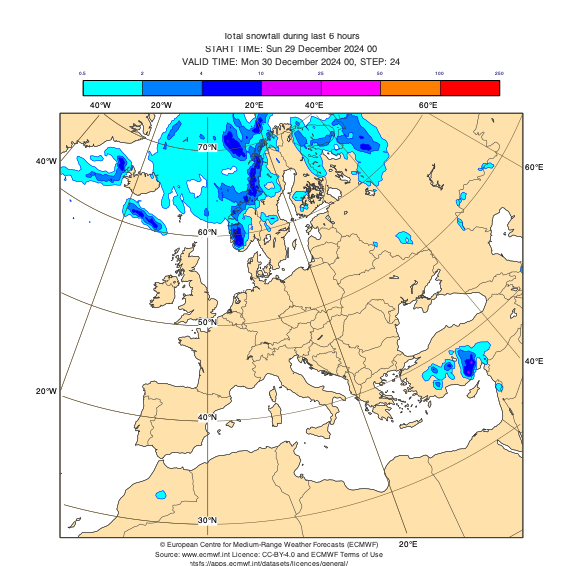

In [9]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
sf_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_blured_f05t300lst")

title = mv.mtext(
    text_lines = ["Total snowfall during last 6 hours",
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' /> ",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' />, STEP: <grib_info key='step' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "htsfs://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, sf, sf_shade, title, ecmwf_text)

To generate the png file you can run the following cell.

In [10]:
png = mv.png_output(
    output_name = "medium-snowfall",    # specify relative or full path
    output_title = "medium-snowfall",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, sf, sf_shade, title, ecmwf_text)

Note that plot produced using open data dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
Open data is on 0.25x0.25 resolution, while high resolution data is 0.1x0.1 grid.